### Сравнение температуры в Омск и Среднего с 3-х

In [24]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

from scripts import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
# Load RP5 (Omsk)
df_omsk = pd.read_csv('RP5/28698.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_omsk.index = pd.to_datetime(df_omsk.index, dayfirst=True)

df_omsk = inp_prep(df_omsk)

df_omsk = df_omsk[['T', 'Po', 'DD', 'Ff', 'N', 'Nh', 'Cl', 'Cm', 'Ch', 'U', 'H', 'RRR']]

df_omsk = conv_wind(df_omsk)
df_omsk = conv_cloud(df_omsk)
df_omsk = conv_cloud(df_omsk, col_name='Nh')

# load kal
df_kal = pd.read_csv('RP5/28696.01.02.2005.03.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_kal.index = pd.to_datetime(df_kal.index, dayfirst=True)

# sel cols
df_kal = df_kal[['T', 'DD', 'Ff', 'N']]
df_kal = conv_cloud(df_kal)
df_kal = df_kal.rename(columns={'T':'T_kal', 'DD':'DD_kal', 'Ff':'fFf_kal', 'N':'N_kal'})

# load sherb
df_sher = pd.read_csv('RP5/28791.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_sher.index = pd.to_datetime(df_sher.index, dayfirst=True)

# sel cols
df_sher = df_sher[['T', 'DD', 'Ff', 'N']]
df_sher = conv_cloud(df_sher)
df_sher = df_sher.rename(columns={'T':'T_sher', 'DD': 'DD_sher', 'Ff': 'Ff_sher', 'N':'N_sher'})

# load sar
df_sar = pd.read_csv('RP5/28598.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_sar.index = pd.to_datetime(df_sar.index, dayfirst=True)

# sel cols
df_sar = df_sar[['T', 'DD', 'Ff', 'N']]
df_sar = conv_cloud(df_sar)
df_sar = df_sar.rename(columns={'T':'T_sar', 'DD':'DD_sar', 'Ff':'Ff_sar', 'N':'N_sar'})

# # to one df
df_three = pd.concat([df_kal, df_sher, df_sar], axis=1)

# select winter periods
df_three_w = select_winter_p(df_three)

df_three_w['three_mean'] = df_three_w[['T_kal', 'T_sher', 'T_sar']].mean(axis=1, skipna=False) # skipna=False Thinking about it???

df_merged = df_omsk.merge(df_three_w, how = 'inner', left_index=True, right_index=True)

df_merged['diff_3'] = df_merged['T'] - df_merged['three_mean']
df_merged['abs_diff_3'] = abs(df_merged['T'] - df_merged['three_mean'])

df_merged = select_winter_p(df_merged)

df_merged = df_merged[df_merged['three_mean'].notna()]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47319 entries, 2021-05-04 15:00:00 to 2005-02-01 06:00:00
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       47319 non-null  float64
 1   Po      47203 non-null  float64
 2   U       47240 non-null  float64
 3   DD      47292 non-null  object 
 4   Ff      47294 non-null  float64
 5   N       47282 non-null  object 
 6   WW      47319 non-null  object 
 7   Tn      6252 non-null   float64
 8   Tx      8686 non-null   float64
 9   Cl      31497 non-null  object 
 10  Nh      39259 non-null  object 
 11  H       39332 non-null  object 
 12  Cm      28710 non-null  object 
 13  Ch      27600 non-null  object 
 14  VV      47270 non-null  object 
 15  Td      47286 non-null  float64
 16  RRR     11792 non-null  object 
dtypes: float64(7), object(10)
memory usage: 6.5+ MB


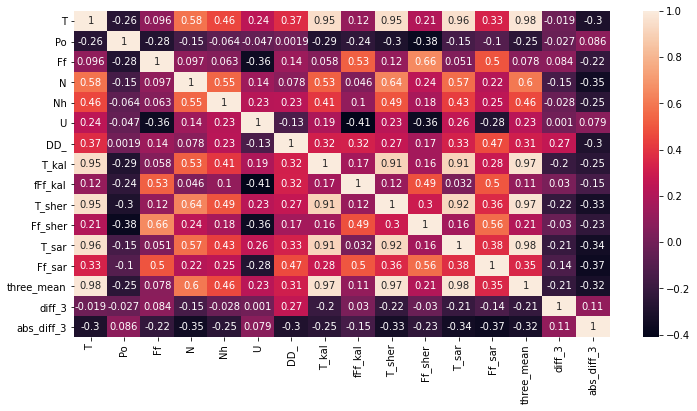

In [38]:
df_merged3 = df_merged.copy()
df_merged3['DD_'] = df_merged3['DD_'].astype('category').cat.codes
sns.heatmap(df_merged3['2014-12'].corr(), annot=True)
plt.rcParams["figure.figsize"] = (12,6)
plt.show()

In [41]:
df_merged.groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()

,DD_,diff_3,abs_diff_3
0,Calm,1.038008,1.591560
1,East,0.700501,1.121756
2,North,0.325088,0.946182
3,South,0.747116,1.135666
4,West,0.628658,0.940487


### Предсказание разницы Омск и 3-х средних ниже

In [46]:
from catboost import CatBoostRegressor

In [121]:
df_merged_c = df_merged.copy()

df_merged_c['DD'] = df_merged_c['DD'].fillna(0)
df_merged_c['DD_'] = df_merged_c['DD'].fillna(0)
df_merged_c['Cl'] = df_merged_c['Cl'].fillna(0)
df_merged_c['Ch'] = df_merged_c['Ch'].fillna(0)
df_merged_c['Cm'] = df_merged_c['Cm'].fillna(0)
df_merged_c['H'] = df_merged_c['H'].fillna(0)
df_merged_c['RRR'] = df_merged_c['RRR'].fillna(0)
df_merged_c['DD_kal'] = df_merged_c['DD_kal'].fillna(0)
df_merged_c['DD_sar'] = df_merged_c['DD_sar'].fillna(0)
df_merged_c['DD_sher'] = df_merged_c['DD_sher'].fillna(0)
df_merged_c['diff_3'] = df_merged_c['diff_3'].fillna(0)

In [ ]:
# Drop Nan'S strategy:
# df_merged_c = df_merged_c[df_merged_c['DD'].notna()]
# df_merged_c = df_merged_c[df_merged_c['DD_'].notna()]
# df_merged_c = df_merged_c[df_merged_c['Cl'].notna()]
# df_merged_c = df_merged_c[df_merged_c['Ch'].notna()]
# df_merged_c = df_merged_c[df_merged_c['Cm'].notna()]


In [124]:
train_data = df_merged_c['2005':'2019-03']
train_data = train_data.drop(columns=['diff_3','abs_diff_3'])
eval_data = df_merged_c['2019-11':]
eval_data = eval_data.drop(columns=['diff_3','abs_diff_3',])
train_labels = df_merged_c['2005':'2019-03']['diff_3']

In [125]:
model = CatBoostRegressor(iterations=1000, 
                           task_type="GPU",
                           devices='0:1')
cat_cols = ['DD', 'DD_', 'Cl', 'Cm','Ch', 'H', 'RRR', 'DD_kal', 'DD_sar', 'DD_sher']

model.fit(train_data,
          train_labels,
          verbose=False,
         cat_features=cat_cols)

In [126]:
preds = model.predict(eval_data)
df_merged_w_preds = df_merged_c['2019-11':].copy()
df_merged_w_preds['diff_p'] = pd.Series(preds, index=df_merged_w_preds.index)
df_merged_w_preds['error'] = abs(df_merged_w_preds['diff_3'] - df_merged_w_preds['diff_p'])

,T,Po,DD,Ff,N,Nh,Cl,Cm,Ch,U,...,N_sher,T_sar,DD_sar,Ff_sar,N_sar,three_mean,diff_3,abs_diff_3,diff_p,error
2019-11-01 00:00:00,2.1,738.5,"Ветер, дующий с юго-востока",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...","Высококучевые просвечивающие, полосами, либо о...",0,85.0,...,60.0,1.0,"Ветер, дующий с юго-востока",4.0,100.0,1.233333,0.866667,0.866667,0.044799,0.821867
2019-11-01 03:00:00,2.6,737.8,"Ветер, дующий с юго-юго-запада",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...","Высококучевые просвечивающие, полосами, либо о...",0,85.0,...,100.0,1.9,"Ветер, дующий с юго-юго-востока",1.0,100.0,3.533333,-0.933333,0.933333,0.402879,1.336213
2019-11-01 06:00:00,4.2,738.4,"Ветер, дующий с западо-юго-запада",2.0,100.0,100.0,Кучево-дождевые волокнистые (часто с наковальн...,0,0,92.0,...,0.0,2.7,"Ветер, дующий с западо-юго-запада",3.0,100.0,6.033333,-1.833333,1.833333,0.441124,2.274457
2019-11-01 09:00:00,3.2,739.6,"Ветер, дующий с западо-юго-запада",6.0,75.0,75.0,Кучево-дождевые волокнистые (часто с наковальн...,"Высококучевых, высокослоистых или слоисто-дожд...","Перистых, перисто-кучевых или перисто-слоистых...",63.0,...,100.0,3.1,"Ветер, дующий с юго-запада",6.0,100.0,5.000000,-1.800000,1.800000,0.060102,1.860102
2019-11-01 12:00:00,1.8,740.8,"Ветер, дующий с западо-юго-запада",5.0,75.0,75.0,Кучево-дождевые волокнистые (часто с наковальн...,"Высококучевых, высокослоистых или слоисто-дожд...","Перистых, перисто-кучевых или перисто-слоистых...",68.0,...,100.0,2.1,"Ветер, дующий с западо-юго-запада",7.0,NaN,1.966667,-0.166667,0.166667,0.372209,0.538875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,755.8,"Ветер, дующий с востока",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Высокослоистые просвечивающие.,0,79.0,...,100.0,-27.2,"Ветер, дующий с востока",2.0,100.0,-25.500000,-0.300000,0.300000,-0.113232,0.186768
2021-02-28 12:00:00,-20.7,753.9,"Ветер, дующий с востока",4.0,100.0,0.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...","Высококучевых, высокослоистых или слоисто-дожд...",Перистые (часто в виде полос) и перисто-слоист...,81.0,...,100.0,-21.1,"Ветер, дующий с востока",3.0,NaN,-20.800000,0.100000,0.100000,0.100808,0.000808
2021-02-28 15:00:00,-17.2,751.9,"Ветер, дующий с востока",5.0,100.0,40.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Высокослоистые непросвечивающие или слоисто-до...,Перистые (часто в виде полос) и перисто-слоист...,80.0,...,100.0,-16.4,"Ветер, дующий с востока",5.0,75.0,-16.700000,-0.500000,0.500000,-0.745718,0.245718
2021-02-28 18:00:00,-17.3,750.1,"Ветер, дующий с востока",6.0,100.0,100.0,Кучево-дождевые волокнистые (часто с наковальн...,0,0,82.0,...,100.0,-16.9,"Ветер, дующий с востока",4.0,NaN,-16.833333,-0.466667,0.466667,-0.311802,0.154865


In [133]:
df_merged_w_preds['error'].mean()

0.4117371041383961

In [132]:
abs(df_merged_w_preds['diff_3']).mean()

1.0959916757148025

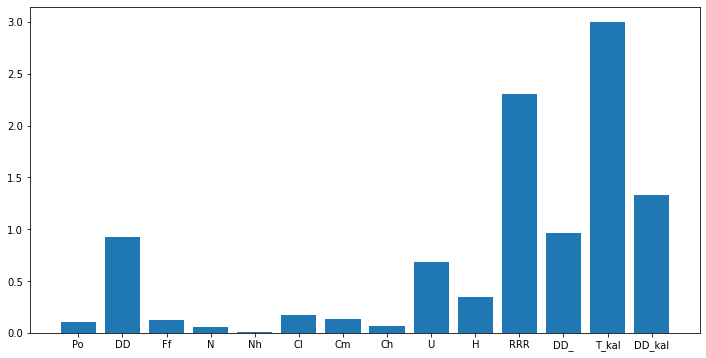

In [134]:
plt.bar(train_data.columns[1:15], model.get_feature_importance()[1:15])
plt.show()